**В данном ноутбуке будут проводиться эксперименты с базовой архитектурой Unet, которая была написана первой**. 

См. папку `Base_Unet`

In [1]:
# Подключаем необходимые библиотеки

import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [55]:
# Определяем гиперпараметры

batch_size = 32
num_epochs = 10
lr = 0.001
device = "cpu"

# Для transform

size = (256, 256)


if torch.cuda.is_available():
    device = torch.cuda

# cuda0 = torch.device('cuda')

print(device)
# print(cuda0)

cpu


In [2]:
# Путь к данным

data_dir = "../../human_poses_data"
train_dir = os.path.join(data_dir, "img_train")
test_dir = os.path.join(data_dir, "img_test")
train_labels_path = os.path.join(data_dir, "train_answers.csv")

# Чтение файла с метками
train_labels = pd.read_csv(train_labels_path)

print(data_dir)
train_labels['target_feature'].max()


FileNotFoundError: [Errno 2] No such file or directory: '../../human_poses_data\\train_answers.csv'

In [57]:
train_labels

,img_id,target_feature
0,17363,2
1,8612,5
2,8244,0
3,9264,0
4,5382,6
...,...,...
12362,11503,4
12363,12201,6
12364,5489,3
12365,883,5


Добавим новые функции для сохранения чекпоинтов и модели.

[Saving and Loading Models](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

In [58]:
# Добавляем новые функции для сохранения чекпоинтов

def save_checkpoint(model, optimizer, epoch, loss, filename="checkpoint.pth"):
    """Сохраняет чекпоинт модели и оптимизатора."""
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "loss": loss,
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved: {filename}, epoch {epoch}, loss {loss:.4f}")

def load_checkpoint(model, optimizer, filename="checkpoint.pth"):
    """Загружает чекпоинт модели и оптимизатора."""
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]
    print(f"Checkpoint loaded: {filename}, epoch {epoch}, loss {loss:.4f}")
    return epoch, loss

In [59]:
from torchvision.transforms.v2 import ToDtype

# Произведем пребразования над данными для последующей их передачи в модель

# transform_train = transforms.Compose([
#     transforms.Resize(size=size), # Уменьшаем и приводим изображения к одному размеру
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])

# transform_test = transforms.Compose([
#     transforms.Resize(size=size), # Уменьшаем и приводим изображения к одному размеру
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])

transform = transforms.Compose([
    transforms.Resize(size=size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [60]:
# # Определим удобный класс Dataset для хранения данных

class HumanPoseDataset(Dataset):
    def __init__(self, img_dir, labels_df=None, transform=None):
        self.img_dir = img_dir
        self.labels_df = labels_df
        self.transform = transform
        self.img_files = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.labels_df) if self.labels_df is not None else len(os.listdir(self.img_dir))
    
    def __getitem__(self, index):
        img_name = self.img_files[index]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.labels_df is not None:
            img_id = int(os.path.splitext(img_name)[0])
            label = self.labels_df.loc[self.labels_df["img_id"] == img_id, "target_feature"].values[0]
            return image, label
        else:
            return image, img_name

In [61]:
# Создаем DataLoader

train_dataset = HumanPoseDataset(train_dir, train_labels, transform=transform)
test_dataset = HumanPoseDataset(test_dir, transform=transform)

# Разделяем обучающий датасет на валидационную и обучающую выборки
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

**Улучшаем класс модели.**

In [62]:
# # # Модернизируем класс

class Unet(nn.Module):
    def __init__(self, num_classes):
        super(Unet, self).__init__()

        # Encoder (снижение пространственного размера)
        self.encoder = nn.Sequential(
            # 3 -> 32
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),  # Пулинг после каждого блока

            # 32 -> 64
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),

            # 64 -> 128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)
        )

        # Decoder (увеличение размерности с помощью ConvTranspose2d)
        self.decoder = nn.Sequential(
            # 128 -> 64
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            # 64 -> 32
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(32),

            # 32 -> num_classes
            nn.Conv2d(32, num_classes, kernel_size=1)  # Финальный слой для сегментации
        )

        # Классификатор (после декодера)
        self.classifier = nn.Sequential(
            nn.Flatten(),  # Преобразуем все кроме batch dimension в одномерный вектор
            nn.Linear(num_classes * 128 * 128, 512),  # Размер зависит от выхода вашего декодера
            nn.ReLU(),
            nn.Linear(512, num_classes)  # Выходной слой для классификации
        )

    def forward(self, x):
        # print(x.shape)
        # Энкодер: последовательность сверток и пулингов
        x = self.encoder(x)
        # print(x.shape)

        # Декодер: последовательность ConvTranspose2d и Conv2d
        x = self.decoder(x)
        # print(x.shape)
        
        # Классификация: Flatten и полносвязные слои
        x = self.classifier(x)
        # print(x.shape)
        return x

In [63]:
# Выведем summary модели
num_classes = len(range(train_labels["target_feature"].min(), train_labels["target_feature"].max()))
print("Кол-во классов:", num_classes)

unet = Unet(num_classes=num_classes + 1).to(device)
print(unet)

Кол-во классов: 18
Unet(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momen

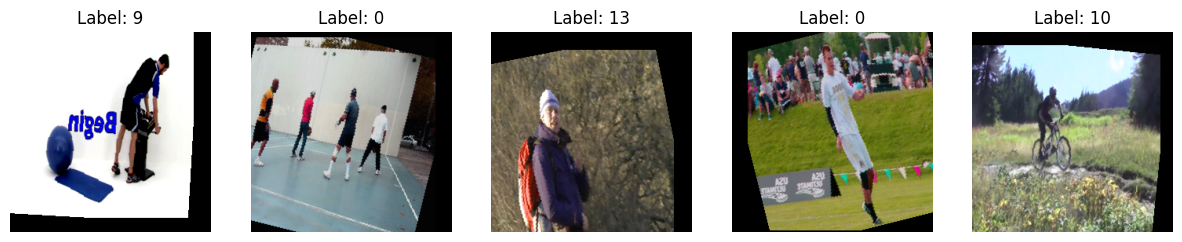

In [64]:
# Посмотрим на картинки в обучающей выборке

# Функция для печатания картинок из датасета
def show_images(dataset, num_images=5):
    """Функция для отображения нескольких изображений из датасета"""
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        image, label = dataset[i]  # Получаем изображение и метку
        image = image.permute(1, 2, 0).numpy()  # Меняем порядок осей для отображения
        image = (image * 0.5 + 0.5)  # Обратно нормализуем для отображения (если нормализовали)
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")
    plt.show()

# Покажем несколько изображений из обучающего набора
show_images(train_dataset, num_images=5)

**Изменим функцию обучения с добавлением чекпоинтов**

In [71]:
# # Функция обучения и оценки 
# def train_and_evaluate(model, criterion, optimizer, train_loader, val_loader, num_epochs, lr=1e-3, checkpoint_dir='./checkpoints'):
#     train_losses, val_losses = [], []
#     val_metrics = []

#     os.makedirs(checkpoint_dir, exist_ok=True)

#     for epoch in range(num_epochs):
#         # Обучение
#         model.train()
#         train_loss = 0
#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)

#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             train_loss += loss.item()

#         train_loss /= len(train_loader)
#         train_losses.append(train_loss)

#         # Оценка
#         model.eval()
#         val_loss = 0
#         all_preds = []
#         all_labels = []
#         with torch.no_grad():
#             for images, labels in val_loader:
#                 images, labels = images.to(device), labels.to(device)
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item()

#                 preds = torch.argmax(outputs, dim=1)
#                 all_preds.extend(preds.cpu().numpy())
#                 all_labels.extend(labels.cpu().numpy())

#         val_loss /= len(val_loader)
#         val_losses.append(val_loss)

#         acc = accuracy_score(all_labels, all_preds)
#         prec = precision_score(all_labels, all_preds, average="weighted")
#         rec = recall_score(all_labels, all_preds, average="weighted")
#         f1 = f1_score(all_labels, all_preds, average="weighted")
#         val_metrics.append((acc, prec, rec, f1))

#         print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
#               f"Val Acc: {acc:.4f}, Val Prec: {prec:.4f}, Val Recall: {rec:.4f}, Val F1: {f1:.4f}")

#         # Сохранение чекпойнтов
#         if (epoch + 1) % 5 == 0:
#             checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch{epoch + 1}_acc{acc:.4f}.pth")
#             torch.save({'epoch': epoch + 1,
#                         'model_state_dict': model.state_dict(),
#                         'optimizer_state_dict': optimizer.state_dict(),
#                         'val_loss': val_loss}, checkpoint_path)

#     return train_losses, val_losses, val_metrics

def train_and_evaluate(model, criterion, optimizer, train_loader, val_loader, num_epochs, 
                       lr=1e-3, checkpoint_dir='./checkpoints', checkpoint_path=None):
    train_losses, val_losses = [], []
    val_metrics = []

    os.makedirs(checkpoint_dir, exist_ok=True)
    start_epoch = 0

    # Загрузка чекпоинта, если он указан
    if checkpoint_path is not None:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Resuming training from epoch {start_epoch}")

    for epoch in range(start_epoch, num_epochs):
        # Обучение
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Оценка
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        acc = accuracy_score(all_labels, all_preds)
        prec = precision_score(all_labels, all_preds, average="weighted")
        rec = recall_score(all_labels, all_preds, average="weighted")
        f1 = f1_score(all_labels, all_preds, average="weighted")
        val_metrics.append((acc, prec, rec, f1))

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Val Acc: {acc:.4f}, Val Prec: {prec:.4f}, Val Recall: {rec:.4f}, Val F1: {f1:.4f}")

        # Сохранение чекпоинтов
        if (epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch{epoch + 1}_acc{acc:.4f}.pth")
            torch.save({'epoch': epoch + 1,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'val_loss': val_loss}, checkpoint_path)

    return train_losses, val_losses, val_metrics

In [66]:
# Определяем критерий и оптимизатор
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(unet.parameters(), lr=lr) 

In [67]:
# Функция для предсказания и сохранения результатов
def predict_and_save(model, test_loader, output_file):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images, ids in test_loader:  # img_name_batch нам не нужен для индексации
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            
            for img_id, pred in zip(ids, preds):
                predictions.append((img_id, pred))

    # Создаем DataFrame с индексами и предсказаниями
    results_df = pd.DataFrame(predictions, columns=['id', 'target_feature'])
    results_df['id'] = results_df['id'].str.replace(".jpg", "")

    # Сохраняем файл в формате CSV
    results_df.to_csv(output_file, index=False)
    print(f"Предсказания сохранены в файл {output_file}")

In [68]:
# Сохраняем модель

torch.save(unet, "unet.pth")

In [73]:
checkpoint_path = "./checkpoints/model_epoch15_acc0.3668.pth"

In [ ]:
# Запуск обучения и валидации. Пример, чтобы посмотреть на изменение
train_losses, val_losses, val_metrics = train_and_evaluate(
    unet, criterion, optimizer, train_loader, val_loader, num_epochs=60, lr=lr) 

c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/60, Train Loss: 2.8956, Val Loss: 2.3893, Val Acc: 0.2487, Val Prec: 0.1606, Val Recall: 0.2487, Val F1: 0.1715


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/60, Train Loss: 2.3628, Val Loss: 2.2942, Val Acc: 0.2725, Val Prec: 0.1861, Val Recall: 0.2725, Val F1: 0.1825


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/60, Train Loss: 2.3109, Val Loss: 2.2646, Val Acc: 0.2863, Val Prec: 0.1940, Val Recall: 0.2863, Val F1: 0.2215


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/60, Train Loss: 2.2260, Val Loss: 2.1538, Val Acc: 0.2992, Val Prec: 0.2394, Val Recall: 0.2992, Val F1: 0.2252


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/60, Train Loss: 2.1763, Val Loss: 2.1639, Val Acc: 0.2907, Val Prec: 0.1767, Val Recall: 0.2907, Val F1: 0.2077


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/60, Train Loss: 2.1506, Val Loss: 2.0942, Val Acc: 0.3114, Val Prec: 0.2656, Val Recall: 0.3114, Val F1: 0.2468


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/60, Train Loss: 2.1112, Val Loss: 2.0712, Val Acc: 0.3385, Val Prec: 0.2799, Val Recall: 0.3385, Val F1: 0.2920


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8/60, Train Loss: 2.0907, Val Loss: 2.2209, Val Acc: 0.2875, Val Prec: 0.2800, Val Recall: 0.2875, Val F1: 0.2392


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9/60, Train Loss: 2.0627, Val Loss: 2.0874, Val Acc: 0.3203, Val Prec: 0.2496, Val Recall: 0.3203, Val F1: 0.2572


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/60, Train Loss: 2.0395, Val Loss: 2.1275, Val Acc: 0.3255, Val Prec: 0.2592, Val Recall: 0.3255, Val F1: 0.2681


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11/60, Train Loss: 2.0311, Val Loss: 2.0680, Val Acc: 0.3340, Val Prec: 0.2996, Val Recall: 0.3340, Val F1: 0.2931


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12/60, Train Loss: 2.0128, Val Loss: 1.9614, Val Acc: 0.3522, Val Prec: 0.3209, Val Recall: 0.3522, Val F1: 0.3215


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 13/60, Train Loss: 1.9702, Val Loss: 1.9774, Val Acc: 0.3518, Val Prec: 0.2891, Val Recall: 0.3518, Val F1: 0.3009


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14/60, Train Loss: 1.9632, Val Loss: 1.9930, Val Acc: 0.3611, Val Prec: 0.3474, Val Recall: 0.3611, Val F1: 0.3306


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 15/60, Train Loss: 1.9446, Val Loss: 1.9444, Val Acc: 0.3668, Val Prec: 0.3149, Val Recall: 0.3668, Val F1: 0.3209


KeyboardInterrupt: 

In [74]:
# Продолжаем обучение с помощью чекпоинта
train_losses, val_losses, val_metrics = train_and_evaluate(
    unet, criterion, optimizer, train_loader, val_loader, num_epochs=60, 
    lr=lr, checkpoint_path=checkpoint_path) 

Resuming training from epoch 15


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 16/60, Train Loss: 1.9168, Val Loss: 1.9540, Val Acc: 0.3736, Val Prec: 0.3419, Val Recall: 0.3736, Val F1: 0.3300


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 17/60, Train Loss: 1.9013, Val Loss: 1.9631, Val Acc: 0.3688, Val Prec: 0.3164, Val Recall: 0.3688, Val F1: 0.3234


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 18/60, Train Loss: 1.8840, Val Loss: 1.8985, Val Acc: 0.3736, Val Prec: 0.4151, Val Recall: 0.3736, Val F1: 0.3369


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 19/60, Train Loss: 1.8688, Val Loss: 1.9195, Val Acc: 0.3736, Val Prec: 0.3510, Val Recall: 0.3736, Val F1: 0.3157


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 20/60, Train Loss: 1.8431, Val Loss: 1.9144, Val Acc: 0.3862, Val Prec: 0.3448, Val Recall: 0.3862, Val F1: 0.3486


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 21/60, Train Loss: 1.8261, Val Loss: 1.8369, Val Acc: 0.4064, Val Prec: 0.4171, Val Recall: 0.4064, Val F1: 0.3679


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 22/60, Train Loss: 1.7973, Val Loss: 1.8707, Val Acc: 0.3854, Val Prec: 0.3974, Val Recall: 0.3854, Val F1: 0.3530


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 23/60, Train Loss: 1.7741, Val Loss: 1.8241, Val Acc: 0.4133, Val Prec: 0.4247, Val Recall: 0.4133, Val F1: 0.3942


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 24/60, Train Loss: 1.7484, Val Loss: 1.8131, Val Acc: 0.4201, Val Prec: 0.3859, Val Recall: 0.4201, Val F1: 0.3916


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 25/60, Train Loss: 1.7295, Val Loss: 1.8768, Val Acc: 0.4007, Val Prec: 0.4981, Val Recall: 0.4007, Val F1: 0.3879


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 26/60, Train Loss: 1.7032, Val Loss: 1.8609, Val Acc: 0.4129, Val Prec: 0.4586, Val Recall: 0.4129, Val F1: 0.3872


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 27/60, Train Loss: 1.6802, Val Loss: 1.7932, Val Acc: 0.4331, Val Prec: 0.4443, Val Recall: 0.4331, Val F1: 0.4034


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 28/60, Train Loss: 1.6459, Val Loss: 1.7603, Val Acc: 0.4315, Val Prec: 0.4569, Val Recall: 0.4315, Val F1: 0.4090


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 29/60, Train Loss: 1.6205, Val Loss: 1.7787, Val Acc: 0.4456, Val Prec: 0.4883, Val Recall: 0.4456, Val F1: 0.4158


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 30/60, Train Loss: 1.6181, Val Loss: 1.7564, Val Acc: 0.4375, Val Prec: 0.4329, Val Recall: 0.4375, Val F1: 0.4175


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 31/60, Train Loss: 1.5765, Val Loss: 1.7010, Val Acc: 0.4626, Val Prec: 0.4882, Val Recall: 0.4626, Val F1: 0.4430


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 32/60, Train Loss: 1.5514, Val Loss: 1.7056, Val Acc: 0.4501, Val Prec: 0.4461, Val Recall: 0.4501, Val F1: 0.4364


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 33/60, Train Loss: 1.5279, Val Loss: 1.7215, Val Acc: 0.4610, Val Prec: 0.4496, Val Recall: 0.4610, Val F1: 0.4409


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 34/60, Train Loss: 1.5129, Val Loss: 1.6958, Val Acc: 0.4581, Val Prec: 0.4665, Val Recall: 0.4581, Val F1: 0.4356


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 35/60, Train Loss: 1.4898, Val Loss: 1.6433, Val Acc: 0.4788, Val Prec: 0.4932, Val Recall: 0.4788, Val F1: 0.4619


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 36/60, Train Loss: 1.4754, Val Loss: 1.6928, Val Acc: 0.4670, Val Prec: 0.4788, Val Recall: 0.4670, Val F1: 0.4536
Epoch 37/60, Train Loss: 1.4274, Val Loss: 1.6308, Val Acc: 0.4844, Val Prec: 0.4984, Val Recall: 0.4844, Val F1: 0.4648


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 38/60, Train Loss: 1.4031, Val Loss: 1.6979, Val Acc: 0.4897, Val Prec: 0.4845, Val Recall: 0.4897, Val F1: 0.4725


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 39/60, Train Loss: 1.3830, Val Loss: 1.6989, Val Acc: 0.4824, Val Prec: 0.5159, Val Recall: 0.4824, Val F1: 0.4797


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 40/60, Train Loss: 1.3614, Val Loss: 1.6370, Val Acc: 0.5030, Val Prec: 0.5106, Val Recall: 0.5030, Val F1: 0.4820


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 41/60, Train Loss: 1.3345, Val Loss: 1.6144, Val Acc: 0.4925, Val Prec: 0.5164, Val Recall: 0.4925, Val F1: 0.4789


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 42/60, Train Loss: 1.3044, Val Loss: 1.6267, Val Acc: 0.5002, Val Prec: 0.4960, Val Recall: 0.5002, Val F1: 0.4833
Epoch 43/60, Train Loss: 1.2763, Val Loss: 1.6270, Val Acc: 0.4970, Val Prec: 0.5160, Val Recall: 0.4970, Val F1: 0.4862


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 44/60, Train Loss: 1.2666, Val Loss: 1.6872, Val Acc: 0.5022, Val Prec: 0.5258, Val Recall: 0.5022, Val F1: 0.4929
Epoch 45/60, Train Loss: 1.2401, Val Loss: 1.6080, Val Acc: 0.5241, Val Prec: 0.5386, Val Recall: 0.5241, Val F1: 0.5183
Epoch 46/60, Train Loss: 1.2191, Val Loss: 1.6836, Val Acc: 0.5160, Val Prec: 0.5298, Val Recall: 0.5160, Val F1: 0.5115
Epoch 47/60, Train Loss: 1.1815, Val Loss: 1.5559, Val Acc: 0.5192, Val Prec: 0.5129, Val Recall: 0.5192, Val F1: 0.5095
Epoch 48/60, Train Loss: 1.1621, Val Loss: 1.6093, Val Acc: 0.5326, Val Prec: 0.5327, Val Recall: 0.5326, Val F1: 0.5267
Epoch 49/60, Train Loss: 1.1659, Val Loss: 1.6054, Val Acc: 0.5233, Val Prec: 0.5318, Val Recall: 0.5233, Val F1: 0.5120
Epoch 50/60, Train Loss: 1.1498, Val Loss: 1.5637, Val Acc: 0.5200, Val Prec: 0.5516, Val Recall: 0.5200, Val F1: 0.5140
Epoch 51/60, Train Loss: 1.1134, Val Loss: 1.5647, Val Acc: 0.5378, Val Prec: 0.5421, Val Recall: 0.5378, Val F1: 0.5263
Epoch 52/60, Train Loss: 1.0724,

In [76]:
torch.save(unet.state_dict(), 'final_unet_60.pth')

In [77]:
# После обучения производим предсказания и сохраняем их в требуемый формат
output_file = "test_predictions.csv"
predict_and_save(unet, test_loader, output_file) 

Предсказания сохранены в файл test_predictions.csv


In [ ]:
# Функция для визуализации графика ошибок и метрик
def visualize_model_results(train_losses, val_losses, val_metrics):
    val_acc = [m[0] for m in val_metrics] 
    val_f1 = [m[3] for m in val_metrics]

    plt.figure(figsize=(12, 6)) 
    plt.subplot(1, 2, 1) 
    plt.plot(range(0, 60), train_losses, label="Train Loss")
    plt.plot(range(0, 60), val_losses, label="Val Loss")
    plt.xlabel("Epoch") 
    plt.ylabel("Loss") 
    plt.title("Training Loss") 
    plt.legend() 

    plt.subplot(1, 2, 2) 
    plt.plot(val_acc, label="Validation Accuracy") 
    plt.plot(val_f1, label="Validation F1-Score") 
    plt.xlabel("Epoch") 
    plt.ylabel("Value") 
    plt.title("Validation Metrics") 
    plt.legend() 

    plt.tight_layout() 
    plt.show()

ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

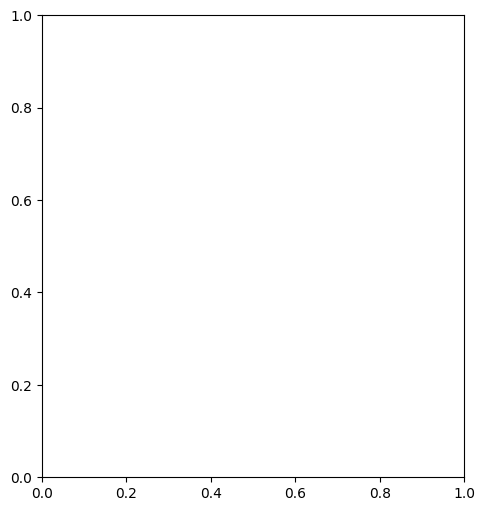

In [121]:
# Визуализация

visualize_model_results(train_losses, val_losses, val_metrics)

In [128]:
pred_file = pd.read_csv('test_predictions.csv')
pred_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5301 entries, 0 to 5300
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              5301 non-null   object
 1   target_feature  5301 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 83.0+ KB


In [131]:
pred_file

,id,target_feature
0,0.jpg,9
1,100.jpg,3
2,10000.jpg,3
3,10003.jpg,9
4,10004.jpg,9
...,...,...
5296,9989.jpg,3
5297,9990.jpg,0
5298,9995.jpg,9
5299,9996.jpg,6


In [132]:
pred_file['id'] = pred_file['id'].str.replace(".jpg", "")
pred_file

,id,target_feature
0,0,9
1,100,3
2,10000,3
3,10003,9
4,10004,9
...,...,...
5296,9989,3
5297,9990,0
5298,9995,9
5299,9996,6


In [133]:
pred_file.to_csv("test_predictions.csv", index=False)

In [123]:
# Функция для сохранения результатов в лог файл
def save_log_model_results(file_name, train_losses, val_losses, val_metrics):
    """
    Сохраняет результаты обучения модели в лог-файл.

    Parameters:
        file_name (str): название файла для сохранения логов.
        train_losses (list, ndarray): список значений ошибки на обучающей выборке.
        val_lossses (list, ndarray): список значений ошибки на валидационной выборке.
        val_metrics (list, ndarray): метрики валидаций
    """

    with open(file_name, "w") as f:
        f.write("Training Results Log\n")
        f.write("=" * 50 + "\n")
        f.write(f"Total Epochs: {len(train_losses)}\n\n")
        
        f.write("Epoch-wise Results:\n")
        for epoch, (train_loss, val_loss, metrics) in enumerate(zip(train_losses, val_losses, val_metrics), start=1):
            acc, prec, rec, f1 = metrics
            f.write(
                f"Epoch {epoch}:\n"
                f"  Train Loss: {train_loss:.4f}\n"
                f"  Val Loss: {val_loss:.4f}\n"
                f"  Val Accuracy: {acc:.4f}\n"
                f"  Val Precision: {prec:.4f}\n"
                f"  Val Recall: {rec:.4f}\n"
                f"  Val F1-Score: {f1:.4f}\n\n"
            )
        f.write("=" * 50 + "\n")
    print(f"Лог результатов сохранен в файл {file_name}")

In [124]:
# Сохраняем результаты первого теста архитектуры
save_log_model_results("unet_base_32.log", train_losses, val_losses, val_metrics )

Лог результатов сохранен в файл unet_base_32.log


**Теперь создадим перебор гиперапараметров для архитектуры, чтобы сравнить и найти лучшие**

*По мере тестирования будем сохранять результаты в лог файлы*

In [ ]:
# Изменим разер батчей на 64 и загрузим данные

batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Запуск обучения с 64 батчами. Пример, чтобы посмотреть на изменение
train_losses, val_losses, val_metrics = train_and_evaluate(unet, train_loader, val_loader, num_epochs=10, lr=lr) 

# Сохранение предсказаний
output_file = "test_predictions_image64.csv"
predict_and_save(unet, test_loader, output_file)

Epoch 1/10, Train Loss: 0.0107, Val Loss: 5.9977, Val Acc: 0.4687, Val Prec: 0.4876, Val Recall: 0.4687, Val F1: 0.4611
Epoch 2/10, Train Loss: 0.0135, Val Loss: 5.1875, Val Acc: 0.4658, Val Prec: 0.4817, Val Recall: 0.4658, Val F1: 0.4608
Epoch 3/10, Train Loss: 0.0283, Val Loss: 5.7862, Val Acc: 0.4590, Val Prec: 0.4940, Val Recall: 0.4590, Val F1: 0.4582
Epoch 4/10, Train Loss: 0.0156, Val Loss: 5.0290, Val Acc: 0.4735, Val Prec: 0.4696, Val Recall: 0.4735, Val F1: 0.4653
Epoch 5/10, Train Loss: 0.0075, Val Loss: 5.6168, Val Acc: 0.4553, Val Prec: 0.4532, Val Recall: 0.4553, Val F1: 0.4470
Epoch 6/10, Train Loss: 0.0076, Val Loss: 5.4753, Val Acc: 0.4626, Val Prec: 0.4628, Val Recall: 0.4626, Val F1: 0.4554
Epoch 7/10, Train Loss: 0.0056, Val Loss: 4.6070, Val Acc: 0.4674, Val Prec: 0.4715, Val Recall: 0.4674, Val F1: 0.4662
Epoch 8/10, Train Loss: 0.0057, Val Loss: 4.5512, Val Acc: 0.4703, Val Prec: 0.4717, Val Recall: 0.4703, Val F1: 0.4643
Epoch 9/10, Train Loss: 0.0042, Val Loss

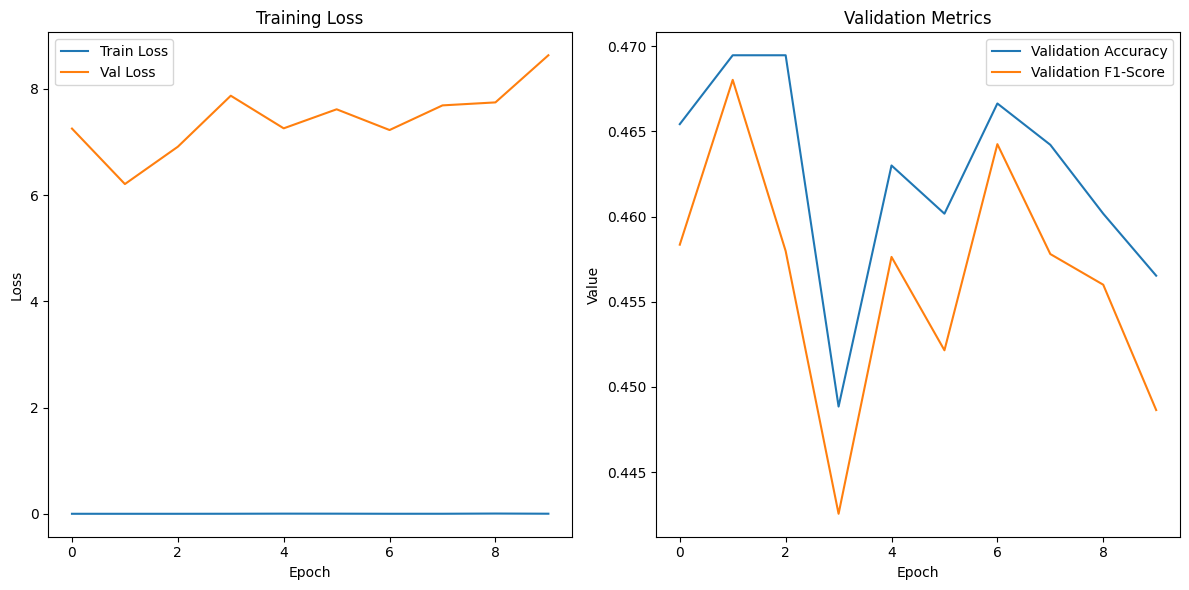

In [ ]:
# Визуализация

visualize_model_results(train_losses, val_losses, val_metrics)

In [ ]:
# Сохраняем результаты первого теста архитектуры с batch_size = 64
save_log_model_results("unet_base_batch_64_size.log", train_losses, val_losses, val_metrics)

Лог результатов сохранен в файл unet_base_batch_64_size.log


In [ ]:
# Теперь с 128 батчами.

batch_size = 128

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Запуск обучения с 128 батчами. Пример, чтобы посмотреть на изменение
train_losses, val_losses, val_metrics = train_and_evaluate(unet, train_loader, val_loader, num_epochs=10, lr=lr) 

# Сохранение предсказаний
output_file = "test_predictions_image128.csv"
predict_and_save(unet, test_loader, output_file)

Epoch 1/10, Train Loss: 0.0013, Val Loss: 6.3375, Val Acc: 0.4844, Val Prec: 0.4797, Val Recall: 0.4844, Val F1: 0.4749
Epoch 2/10, Train Loss: 0.0043, Val Loss: 7.4087, Val Acc: 0.4622, Val Prec: 0.4738, Val Recall: 0.4622, Val F1: 0.4463
Epoch 3/10, Train Loss: 0.0118, Val Loss: 7.1495, Val Acc: 0.4679, Val Prec: 0.4797, Val Recall: 0.4679, Val F1: 0.4612
Epoch 4/10, Train Loss: 0.0117, Val Loss: 7.3355, Val Acc: 0.4658, Val Prec: 0.4750, Val Recall: 0.4658, Val F1: 0.4601
Epoch 5/10, Train Loss: 0.0025, Val Loss: 7.8663, Val Acc: 0.4581, Val Prec: 0.4649, Val Recall: 0.4581, Val F1: 0.4509
Epoch 6/10, Train Loss: 0.0012, Val Loss: 7.5632, Val Acc: 0.4594, Val Prec: 0.4655, Val Recall: 0.4594, Val F1: 0.4567
Epoch 7/10, Train Loss: 0.0021, Val Loss: 7.1935, Val Acc: 0.4610, Val Prec: 0.4593, Val Recall: 0.4610, Val F1: 0.4557
Epoch 8/10, Train Loss: 0.0016, Val Loss: 6.9093, Val Acc: 0.4561, Val Prec: 0.4544, Val Recall: 0.4561, Val F1: 0.4513
Epoch 9/10, Train Loss: 0.0006, Val Loss

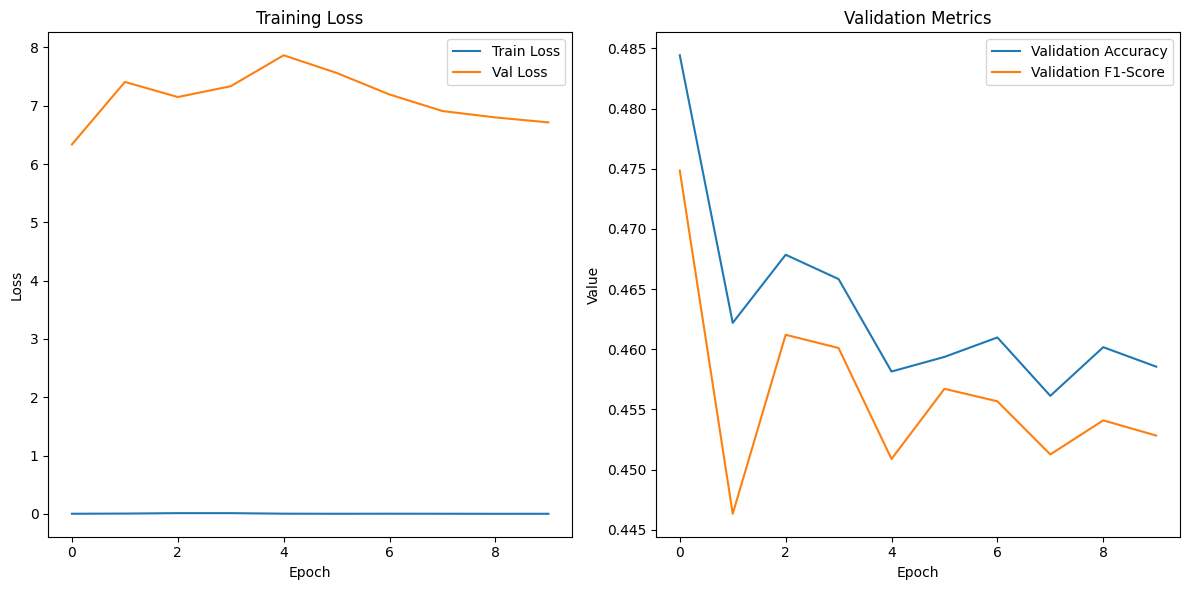

In [ ]:
# Визуализация

visualize_model_results(train_losses, val_losses, val_metrics)

In [ ]:
# Сохраняем результаты первого теста архитектуры с batch_size = 128
save_log_model_results("unet_base_batch_128_size.log", train_losses, val_losses, val_metrics)

Лог результатов сохранен в файл unet_base_batch_128_size.log


In [ ]:
# Теперь для 256 батчей.

batch_size = 256

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Запуск обучения с 256 батчами. Пример, чтобы посмотреть на изменение
train_losses, val_losses, val_metrics = train_and_evaluate(unet, train_loader, val_loader, num_epochs=10, lr=lr) 

# По аналогии сохраняем предсказания
output_file = "test_predictions_image256.csv"
predict_and_save(unet, test_loader, output_file)

Epoch 1/10, Train Loss: 0.0012, Val Loss: 7.2521, Val Acc: 0.4654, Val Prec: 0.4604, Val Recall: 0.4654, Val F1: 0.4584
Epoch 2/10, Train Loss: 0.0010, Val Loss: 6.2079, Val Acc: 0.4695, Val Prec: 0.4779, Val Recall: 0.4695, Val F1: 0.4680
Epoch 3/10, Train Loss: 0.0011, Val Loss: 6.9106, Val Acc: 0.4695, Val Prec: 0.4655, Val Recall: 0.4695, Val F1: 0.4580
Epoch 4/10, Train Loss: 0.0019, Val Loss: 7.8708, Val Acc: 0.4488, Val Prec: 0.4565, Val Recall: 0.4488, Val F1: 0.4426
Epoch 5/10, Train Loss: 0.0039, Val Loss: 7.2569, Val Acc: 0.4630, Val Prec: 0.4737, Val Recall: 0.4630, Val F1: 0.4576
Epoch 6/10, Train Loss: 0.0033, Val Loss: 7.6152, Val Acc: 0.4602, Val Prec: 0.4646, Val Recall: 0.4602, Val F1: 0.4522
Epoch 7/10, Train Loss: 0.0016, Val Loss: 7.2249, Val Acc: 0.4666, Val Prec: 0.4716, Val Recall: 0.4666, Val F1: 0.4643
Epoch 8/10, Train Loss: 0.0017, Val Loss: 7.6889, Val Acc: 0.4642, Val Prec: 0.4634, Val Recall: 0.4642, Val F1: 0.4578
Epoch 9/10, Train Loss: 0.0058, Val Loss

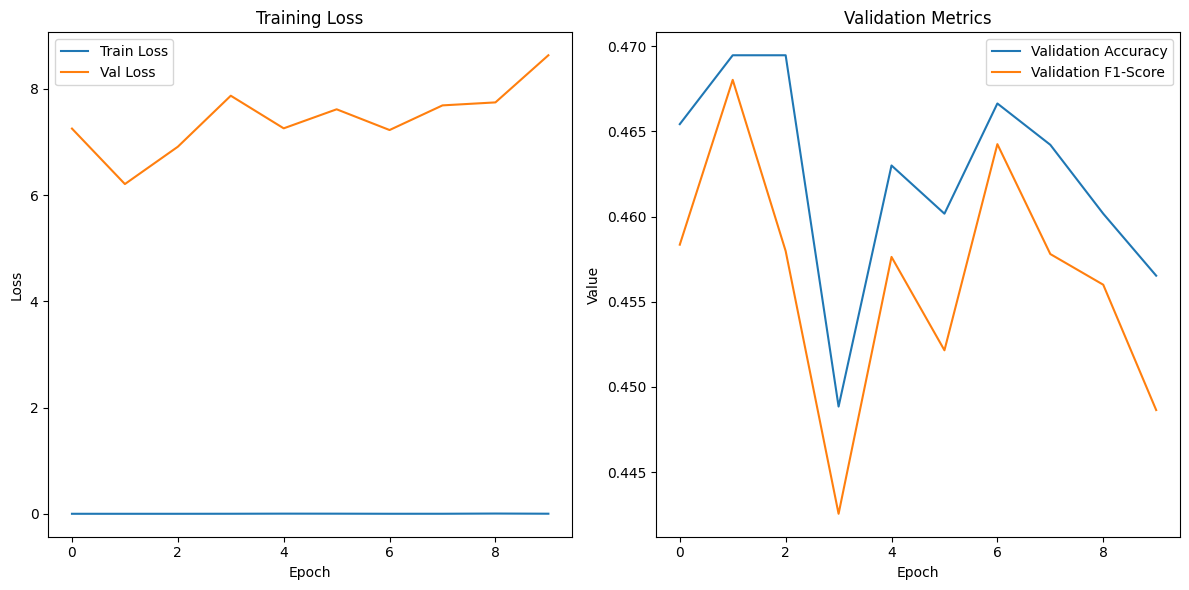

In [ ]:
# Визуализация

visualize_model_results(train_losses, val_losses, val_metrics)

In [ ]:
# Сохраняем результаты первого теста архитектуры с batch_size = 256
save_log_model_results("unet_base_batch_256_size.log", train_losses, val_losses, val_metrics)

Лог результатов сохранен в файл unet_base_batch_256_size.log


**Выводы**: По итогам можно заметить, что данная архитектура имеет довольно высокий accuracy и f1-score, однако график ошибок сигнализирует о сильном переобучении, валидационная ошибка большая, обучающая очень маленькая, что говорит о том, что модель на этапе обучения сильно преспосабливается к данным. Видимо нужно произвести какие то действия с данными, либо упростить модель.